<a href="https://www.kaggle.com/code/kashikamahajan2005/nlp-sentiment-analysis?scriptVersionId=192720346" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **NLP Challenge: IMDB Dataset of 50K Movie Reviews to perform Sentiment analysis**
This model uses various NLP libraries to clean the movie reviews and then give a sentinent analysis (positive or negative) for a review. Due to technical restrictions, I was only able to train the model with 1000 reviews. The approach uses three forms of sentiment analysis and those are then pipelined into a Random Forest Regressor
* TextBlob sentiment value
* BERT sentiment analysis
* k-means clustering

In [1]:
import numpy as np 
import pandas as pd
import nltk
from nltk.corpus import stopwords
import spacy
from nltk.stem.porter import *
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from transformers import pipeline
import time
from transformers import BertTokenizer
import math

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data=pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

2024-08-15 06:46:31.835274: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 06:46:31.835410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 06:46:31.993601: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [2]:
# Dropping any duplicate or null values

data=data.dropna(axis=0,how='any')
data=data.drop_duplicates(subset='review')
data.describe()

,review,sentiment
count,49582,49582
unique,49582,2
top,One of the other reviewers has mentioned that ...,positive
freq,1,24884


In [3]:
# Due to technical restraints, only 1000 reviews could have been analysed for a reasonable runtime

data=data.iloc[:5000]
bert_data=data.iloc[:5000]

# **Data Cleaning**
The following blocks pertain to cleaning the data. The data is cleaned in two ways:
* **K-means and spacy:** The data has any punctuation and stop words removed. The remaining words are then taken in their stem form, which will facilitate a more accurate word vectorisation for k-means
* **BERT:** The data does not have its stop words or necessary punctuation removed. BERT needs stop words such as 'no, not, never' to make a more accurate analysis. 

In [4]:
#Loading variables to be used in functions below

remove_chars='0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~'
remove_bert_chars='"#$%&\'()*+-/:;<=>?@[\\]^_{|}~'
nlp = spacy.load("en_core_web_sm")

In [5]:
#method to clean data for spacy and kmeans
def clean_data(review):
    
    #Removing punctuation
    for char in remove_chars:
        review = review.replace(char, ' ')
    
    #Tokenisation using spacy
    review=review.lower()
    doc=nlp(review)
    
    #removing stop words
    rem_words=[token.text for token in doc if not token.is_stop]
    rem_review=" ".join(rem_words)
    review= rem_review
    
    #removing 'br' html tags and any word that is less than 3 letters
    rem_words=[x for x in rem_words if not x=="br" and len(x)>2]
    rem_review=" ".join(rem_words)
    review= rem_review
    
    #Lemmatization
    doc=nlp(review)
    rem_words=[token.lemma_ for token in doc if not token.is_stop]
    rem_words=[x.strip() for x in rem_words]
    rem_review=" ".join(rem_words)
    review= rem_review
    
    return str(review)

start=time.time()
#data['review'] = data['review'].apply(lambda x: clean_data(x))
end=time.time()
print('Time taken for data cleaning for kmeans and spacy:',(end-start))


Time taken for data cleaning for kmeans and spacy: 2.8133392333984375e-05


In [6]:
#method for cleaning data for BERT sentiment analysis
def clean_bert_data(rev):
    #removing any punctuation which is not needed
    for char in remove_bert_chars:
        rev = rev.replace(char, '')
    rev=rev.replace('br','')
    rev=rev.lower()
    return str(rev)


start=time.time()
bert_data['review'] = bert_data['review'].apply(lambda x: clean_bert_data(x))
end=time.time()
print('Time taken for data cleaning for BERT:',(end-start))


Time taken for data cleaning for BERT: 0.15393948554992676


# **Sentiment Analysis**
The next part of the code deals with using TextBlob and BERT for sentiment analysis
* **TextBlob:**: Since the TextBlob sentiment analysis primarily focuses on the positive or negative words and their frequency, a more rigourisly cleaned form of the data is given. Any stop words and punctuation are removed. Only polarity is assessed in this form of analysis, not the subjectivity of the review. This austere form of sentimental analysis is helpful when models like BERT, which are more sensitive, give a wrong sentiment analysis, as seen in data[1] where mentions of gore and horor taint the label prediction resulting in NEGATIVE when it should be POSITIVE
* **BERT:** While TextBlob gives a good enough prediciton of the sentiment, there are certain reviews, such as data[7] entry which due to use of negation,('not nearly good enough') is misinterpreted by the TextBlob sentiment analysis after remobing of stop words. BERT is more adept at analysing such reviews. 

Both the models have their merits and demerits. Using both the models allows this program to predict the analysis accurately.

In [7]:
#method for getting the sentiment value of a review using TextBlob
def get_sent_values(review):
    blob=TextBlob(review)
    sent_values=[blob.sentiment.polarity,blob.sentiment.subjectivity]
    #print(sent_values)
    return sent_values

start=time.time()
data_sentiment=[]
reviews=data['review']
data_sentiment.append(reviews.apply(lambda x: get_sent_values(x)))
data_sentiment=data_sentiment[0]
end=time.time()

print('Time taken for sentiment analysis for TextBlob:',(end-start))

Time taken for sentiment analysis for TextBlob: 12.388923645019531


In [8]:
#method for gettig the BERT sentiment analysis of a string and then sending a numerical value
def get_bert_values(sentence):
    value=classifier(sentence)
    value=value[0]
    if(value['label'] == 'NEGATIVE'):
        return(-1*value['score'])
    else:
        return(value['score'])
    

#method for cutting each review in chunks and sending it for BERT analysis and compiling the final sentiment value
def review_bert_analysis_by_sentence(review):
    tokens = tokenizer(review, return_tensors='pt', truncation=False, padding=False)['input_ids']
    max_chunk_size = 500

    # Split the tokens into chunks of 512 tokens each since BERT transformer only takes 512 tokens at once
    chunks = []
    for i in range(0, tokens.size(1), max_chunk_size):  # Subtracting 2 to account for special tokens
        chunk = tokens[:, i:i + max_chunk_size]
        chunks.append(chunk)
        
    outputs = []
    for chunk in chunks:
        chunk_text = tokenizer.decode(chunk[0], skip_special_tokens=True)
        output = get_bert_values(chunk_text)
        outputs.append(output)

    # Finding the mean of all sentiment values of a review
    total_bert_value = np.mean(outputs)

    return total_bert_value
    
start=time.time()
bert_values=bert_data['review'].apply(lambda x: review_bert_analysis_by_sentence(x))
end=time.time()
print('Time taken for sentiment analysis for BERT:',(end-start))


Token indices sequence length is longer than the specified maximum sequence length for this model (657 > 512). Running this sequence through the model will result in indexing errors


Time taken for sentiment analysis for BERT: 1455.5179569721222


In [9]:
bert_values

0      -0.973026
1       0.999001
2       0.999102
3      -0.996038
4       0.999302
          ...   
4998   -0.004410
4999   -0.999810
5000   -0.700940
5001    0.999507
5002   -0.855451
Name: review, Length: 5000, dtype: float64

In [10]:
data_sentiment

0       [0.023433179723502305, 0.4903686635944701]
1         [0.1097222222222222, 0.5593434343434344]
2        [0.35400793650793644, 0.6587301587301588]
3                [-0.0578125, 0.45416666666666666]
4        [0.2179522497704316, 0.45291551882460973]
                           ...                    
4998     [0.05605595702998302, 0.5047262261547975]
4999    [-0.3597222222222223, 0.49027777777777776]
5000     [0.13333333333333333, 0.3910256410256411]
5001                 [-0.14401041666666664, 0.675]
5002    [0.17663690476190474, 0.39043650793650797]
Name: review, Length: 5000, dtype: object

In [11]:
polarity=[]
for row in data_sentiment:
    polarity.append(row[0])

In [12]:
data.describe()

,review,sentiment
count,5000,5000
unique,5000,2
top,One of the other reviewers has mentioned that ...,negative
freq,1,2531


In [13]:
data[:10]

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


# **KMEANS Approach**
In the next part, the data reviews are first vectorised and fit into a k-means model. The aim of this is to speed the prediction of sentiment as two clusters will be formed with one being positive and the other being negative. The predicted cluster will again be used in the RFR. 

[NOTE: In this version the kmeans value is not used in the final model as not enough data could have been processed to provide accurate kmeans clusters

In [14]:
vectorizer = CountVectorizer()
X_v = vectorizer.fit_transform(data.review)
X_a=X_v.toarray()

In [15]:
kmeans = KMeans(n_clusters=2,n_init=10, random_state=1).fit(X_a)
labels=kmeans.labels_
label_mapper={0:'positive',1:'negative'}
predicted_labels_kmeans=[label_mapper[i] for i in labels]

# **Final Data Gathering**
All the values attained from data cleaning and analysis are then processed to be added to the dataframe which will be transformed and fit. To make the data more readble for humans when assessing accuracy it is mapped for words only for convienience. But to make the model more accurate, data is made numerical. 

In [16]:
predicted_labels_sentiment=['positive' if i > 0 else 'negative' for i in polarity]
sentiment_mapper={'positive':0,'negative':1}
num_sentiment=[sentiment_mapper[i] for i in data.sentiment]

In [17]:
data.insert(1, 'polarity',polarity, True )
data.insert(1, 'BERT values',bert_values, True )
data.insert(1, 'kmeans pred',labels, True )

In [18]:
data.insert(4, 'sentiment_num',num_sentiment, True )
data[:10]

,review,kmeans pred,BERT values,polarity,sentiment_num,sentiment
0,One of the other reviewers has mentioned that ...,0,-0.973026,0.023433,0,positive
1,A wonderful little production. <br /><br />The...,0,0.999001,0.109722,0,positive
2,I thought this was a wonderful way to spend ti...,0,0.999102,0.354008,0,positive
3,Basically there's a family where a little boy ...,0,-0.996038,-0.057813,1,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",0,0.999302,0.217952,0,positive
5,"Probably my all-time favorite movie, a story o...",0,0.999647,0.155294,0,positive
6,I sure would like to see a resurrection of a u...,0,0.868031,0.285522,0,positive
7,"This show was an amazing, fresh & innovative i...",0,-0.999587,0.082716,1,negative
8,Encouraged by the positive comments about this...,0,-0.999625,-0.142863,1,negative
9,If you like original gut wrenching laughter yo...,0,0.999773,0.415000,0,positive


# **Random Foresst Regressor**
The model is now being trained with the BERT values and polarity. Using this supervised machine learning model, the numerical data is used to predict the sentiment of a review, which is again a numerical value ranging from 0 to 1, since the original labels were mapped (positive: 0 and negative: 1)

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

features = ['BERT values','polarity']
X = data[features]
y = data.sentiment_num

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
rf_model = RandomForestRegressor(random_state=1)

rf_model.fit(train_X, train_y)
rf_pred=rf_model.predict(val_X)


rf_val_mae = mean_absolute_error(rf_pred,val_y)

print("Validation MAE for Random Forest Model: {}".format(rf_val_mae))

Validation MAE for Random Forest Model: 0.14597600000000002


In [20]:
#Since the predictions were made with a range of 0-1, the final prediction is further mapped to 0s and 1s 
num_rf_pred=[]
for x in rf_pred:
    if x<0.5:
        num_rf_pred.append(0)
    else: num_rf_pred.append(1)
val_y=val_y.to_numpy()

# **Assessing Model Accuracy**

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(X_a)

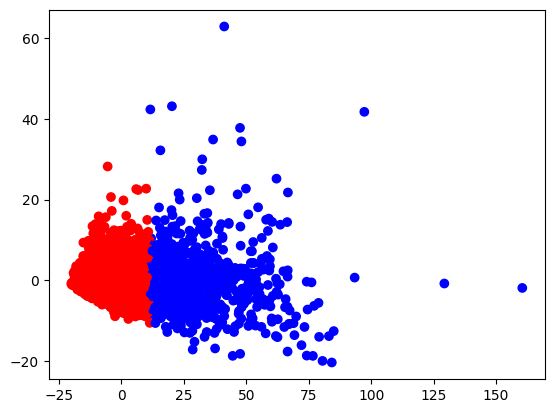

In [22]:
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(X_a)

colors = ["r", "b"]
x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]

plt.scatter(x_axis, y_axis, c=[colors[d] for d in labels])
plt.show()

In [23]:
true_labels=data.sentiment.values

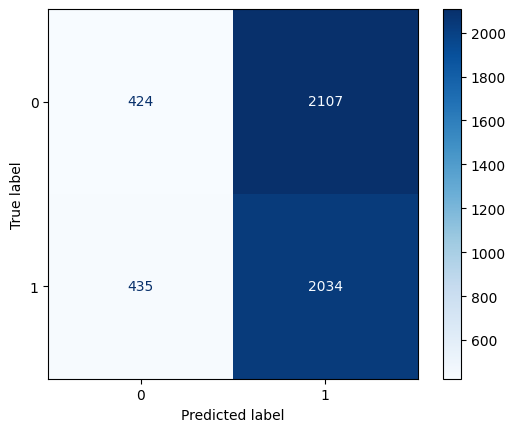

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predicted_labels_kmeans)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

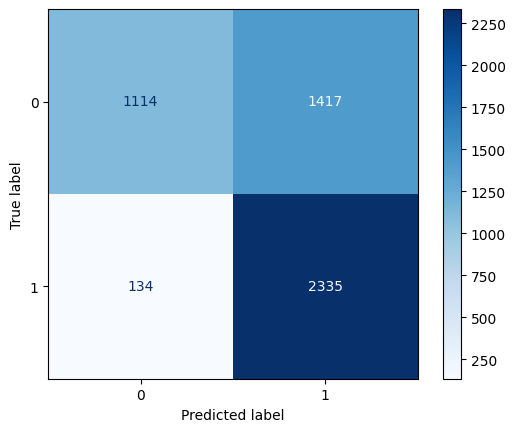

In [25]:
cm = confusion_matrix(true_labels, predicted_labels_sentiment)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# **Final Assessment**
The following Confusion Matrix visualises the accuracy of the above model with the predictions made for the testing data

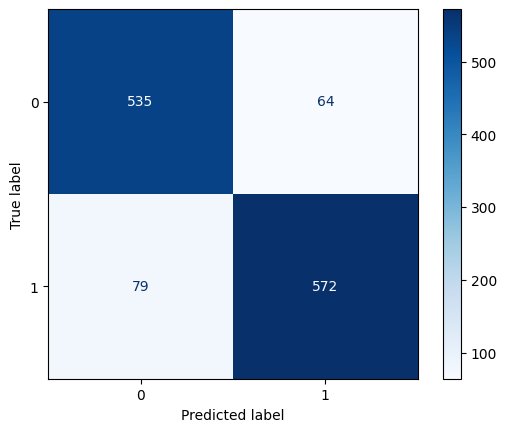

1250

In [26]:
cm = confusion_matrix(val_y, num_rf_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

len(val_y)